In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import recall_score, make_scorer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.metrics import fbeta_score, make_scorer
from fmri_processing import *

def train_best_model_by_recall_adasyn(train_matrix, target_class=1, random_state=42, verbose=True):
    # 1. Загрузка данных
    matrix = np.load(train_matrix)
    X = matrix
    
    # Создание меток (4-й ответ в каждом блоке из 5 - ложный)
    labels = np.zeros(X.shape[0], dtype=int)
    labels[3::5] = 1  
    
    # Группы для валидации (по испытуемым)
    groups = np.repeat(np.arange(X.shape[0] // 5), 5)

    # 2. Пайплайн с ADASYN
    def create_pipeline(model):
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('adasyn', ADASYN(random_state=random_state)),  # <-- Изменено здесь
            ('feature_selector', 'passthrough'),
            ('model', model)
        ])

    # 3. Модели и параметры (без изменений)
    models = {
        "Logistic Regression": {
            'pipeline': create_pipeline(LogisticRegression(max_iter=1000)),
            'params': {
                'feature_selector': [
                    SelectFromModel(LogisticRegression(penalty='l1', solver='saga', random_state=random_state)),
                    PCA(n_components=0.95)
                ],
                'model__C': [0.1, 1, 10, 100],
                'model__class_weight': ['balanced', None],
                'model__solver': ['lbfgs', 'saga', 'liblinear']
            }
        },
        "Random Forest": {
            'pipeline': create_pipeline(RandomForestClassifier()),
            'params': {
                'feature_selector': [
                    SelectFromModel(RandomForestClassifier(random_state=random_state)),
                    RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=50)
                ],
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [None, 10, 20],
                'model__class_weight': ['balanced_subsample', None]
            }
        },
        "SVM": {
            'pipeline': create_pipeline(NuSVC(probability=True)),
            'params': {
                'feature_selector': [PCA(n_components=0.95)],
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf'],
                'model__class_weight': ['balanced']
            }
        },
        "XGBoost": {
            'pipeline': create_pipeline(XGBClassifier()),
            'params': {
                'feature_selector': [SelectFromModel(XGBClassifier(random_state=random_state))],
                'model__n_estimators': [100, 200],
                'model__max_depth': [3, 5, 7],
                'model__learning_rate': [0.01, 0.1, 0.2],
                'model__subsample': [0.8, 1.0]
            }
        }
    }

    # 4. Обучение с групповой валидацией (без изменений)
    optimized_models = {}
    # recall_scorer = make_scorer(recall_score, pos_label=target_class)
    # balanced_acc_scorer = make_scorer(balanced_accuracy_score)
    f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=target_class)

    for name, config in models.items():
        cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
        gs = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['params'],
            cv=cv_strategy,
            scoring=f2_scorer,
            n_jobs=-1,
            verbose=0
        )
        gs.fit(X, labels, groups=groups)
        optimized_models[name] = gs.best_estimator_
        
        if verbose:
            print(f"{name} - Лучшие параметры: {gs.best_params_}")
            print(f"Recall (CV): {gs.best_score_:.3f}\n")

    # 5. Визуализация (без изменений)
    if verbose:
        for model_name, model in optimized_models.items():
            try:
                importances = model.named_steps['model'].feature_importances_
                plt.figure(figsize=(12, 6))
                plt.bar(range(len(importances)), importances)
                plt.title(f"Важность признаков ({model_name})")
                plt.xlabel("Номер региона мозга")
                plt.ylabel("Важность")
                plt.show()
            except AttributeError:
                if isinstance(model.named_steps['feature_selector'], PCA):
                    pca = model.named_steps['feature_selector']
                    plt.figure(figsize=(12, 6))
                    plt.plot(np.cumsum(pca.explained_variance_ratio_))
                    plt.title(f"Накопленная дисперсия (PCA) - {model_name}")
                    plt.xlabel("Число компонент")
                    plt.ylabel("Дисперсия")
                    plt.grid(True)
                    plt.show()

    # 6. Создание стекинг-ансамбля (без изменений)
    ensemble = StackingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        final_estimator=SVC(max_iter=1000, class_weight='balanced'),
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # 7. Оценка ансамбля с ADASYN
    logo = LeaveOneGroupOut()
    # balanced_acc_scores = []
    f2_scores = []
    
    for train_idx, val_idx in logo.split(X, labels, groups=groups):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        adasyn = ADASYN(random_state=random_state)  # <-- Изменено здесь
        X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)
        
        ensemble.fit(X_train_bal, y_train_bal)
        y_pred = ensemble.predict(X_val)
        # recall_scores.append(recall_score(y_val, y_pred, pos_label=target_class))
        # balanced_acc_scores.append(balanced_accuracy_score(y_val, y_pred))
        f2_scores.append(balanced_accuracy_score(y_val, y_pred))
    
    if verbose:
        print(f"Ансамбль (ADASYN) - Recall: {np.mean(f2_scores):.3f} ± {np.std(f2_scores):.3f}")
    
    return {'models': optimized_models, 'ensemble': ensemble.fit(X, labels)}

In [154]:
def train_and_predict_on_test(train_matrix, test_matrix):
    models = train_best_model_by_recall(train_matrix)
    model = models['models']['SVM']
    # model = models['ensemble']
    matrix_test = np.load(test_matrix)
    N_test = matrix_test.shape[0]  # Длина массива

    labels_test = np.zeros(N_test, dtype=int)  # Создаем массив из нулей
    labels_test[3::5] = 1  # Каждый 4-й элемен
    print(model.predict(matrix_test))
    print(classification_report(labels_test, model.predict(matrix_test)))
    return

def train_different_params(train_matrix_base, test_matrix_base):
    for func_name in funcs.keys():
        if func_name in ('max_min', 'min', 'auc'):
            continue
        train_matrix = os.path.join(train_matrix_base, func_name + '.npy')
        test_matrix = os.path.join(test_matrix_base, func_name + '.npy')

        train_and_predict_on_test(train_matrix, test_matrix)

# Просто баллы

In [5]:
ranks_train_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_hc_data'
ranks_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_test_data'
ranks_schz_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_schz_data'
ranks_card_hc_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_card_hc_data'
ranks_card_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_card_test_data'
# train - test
# train_different_params(ranks_train_matrix, ranks_test_matrix)

# test - train
# train_different_params(ranks_test_matrix, ranks_train_matrix)

# train - card
train_different_params(ranks_test_matrix, ranks_card_test_matrix)


NameError: name 'train_different_params' is not defined

# Пропорциональные баллы

In [6]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_hc_data'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_test_data'

schz_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_schz_data'

cards_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/proportional/raw_card_hc_data'

# train - test
# train_different_params(train_matrix_base, test_matrix_base)

# test - train
train_different_params(test_matrix_base, train_matrix_base)

NameError: name 'train_different_params' is not defined

# Баллы 1-2

In [7]:
reduced_train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_hc_data'
reduced_test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_test_data'


reduced_schz_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_schz_data'

reduced_cards_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_card_hc_data'

# train - test 
# train_different_params(reduced_train_matrix_base, reduced_test_matrix_base)

# test - train
train_different_params(reduced_test_matrix_base, reduced_train_matrix_base)

# train_different_params(reduced_train_matrix_base, reduced_schz_matrix_base)

# train_different_params(reduced_train_matrix_base, reduced_cards_matrix_base)

NameError: name 'train_different_params' is not defined

# Усреднение стимула

In [8]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/hc_data'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/test_data'

schz_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/schz_data'
card_train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_hc_data'
card_test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_test_data'

# train_different_params(train_matrix_base, card_train_matrix_base)
# print('SCHZ'*20)

# train - test
# train_different_params(train_matrix_base, test_matrix_base)

# test - train
train_different_params(test_matrix_base, train_matrix_base)

NameError: name 'train_different_params' is not defined

In [9]:
def draw_all_subjects(matrix):
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5

    subjects = np.array_split(matrix, sub_num)
    for idx, sub in enumerate(subjects):
        print(f'sub-{idx:02d}')
        draw_heat_map(subjects[idx])

sub-00


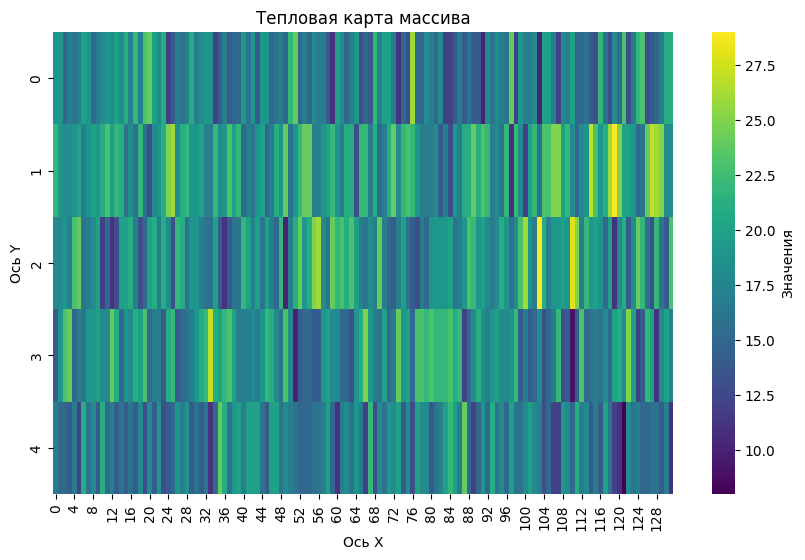

sub-01


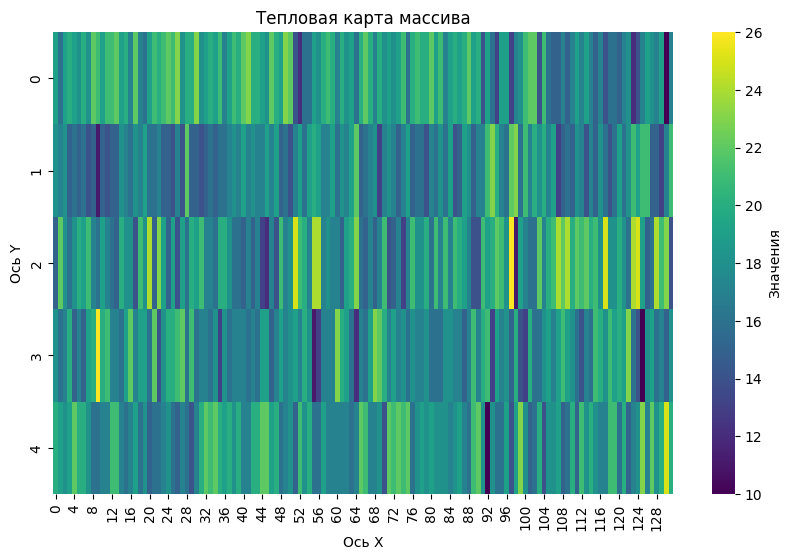

sub-02


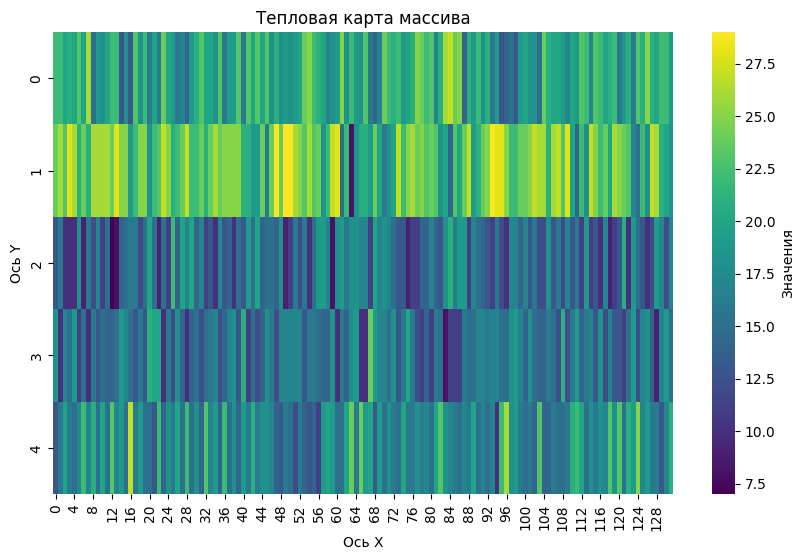

sub-03


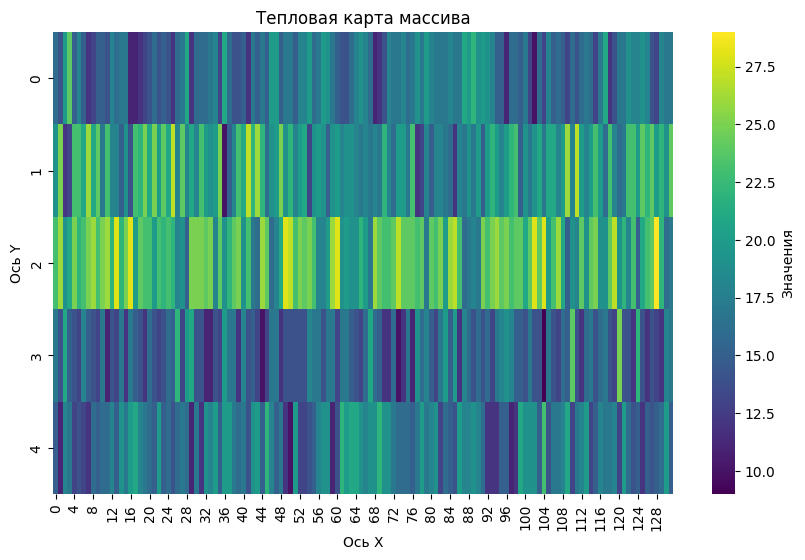

sub-04


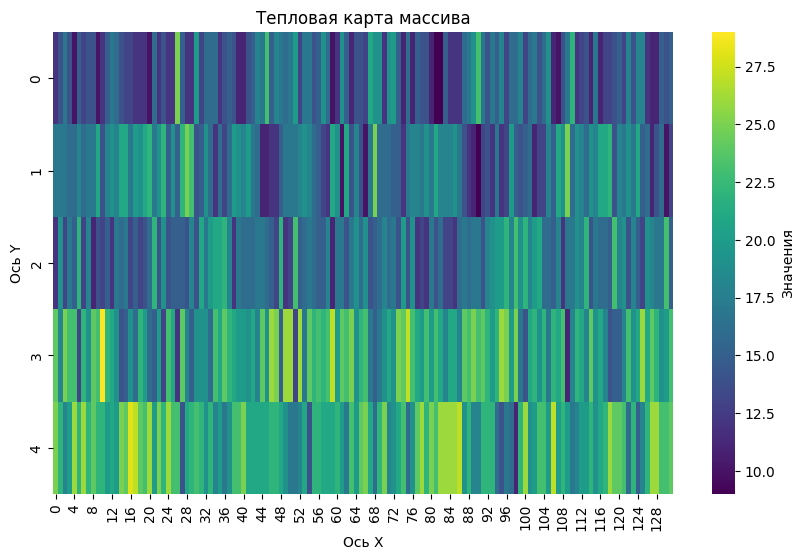

sub-05


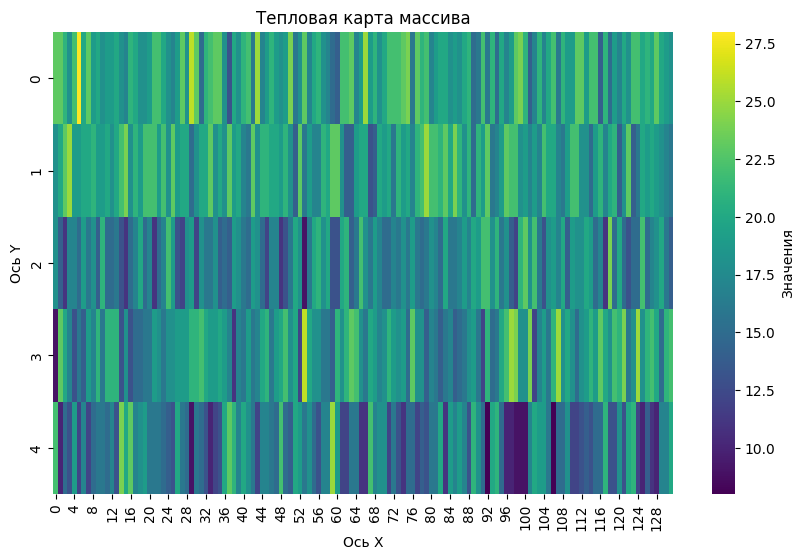

sub-06


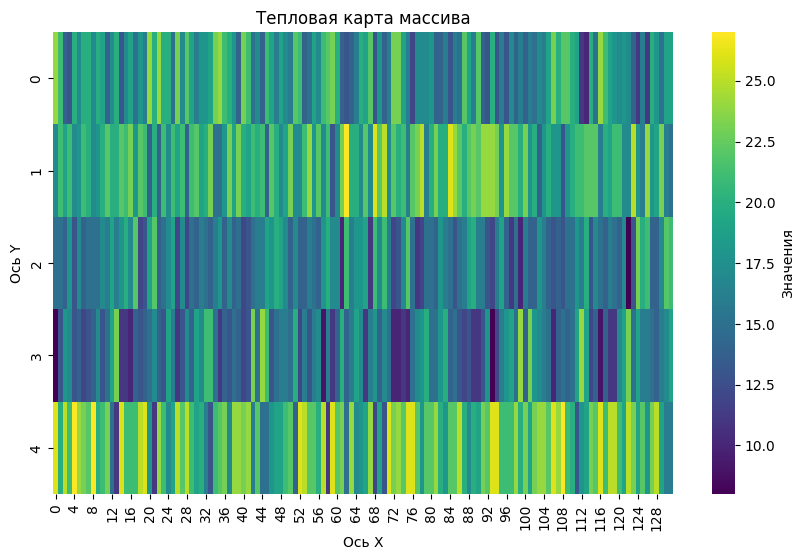

sub-07


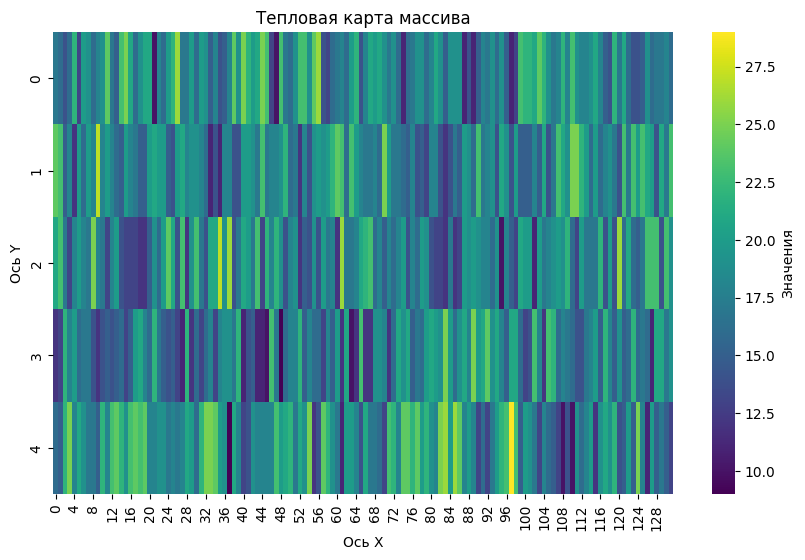

sub-08


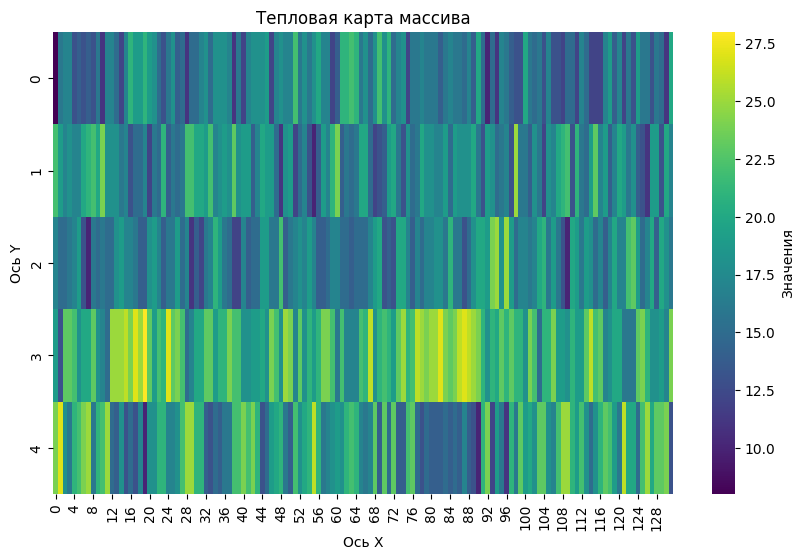

sub-09


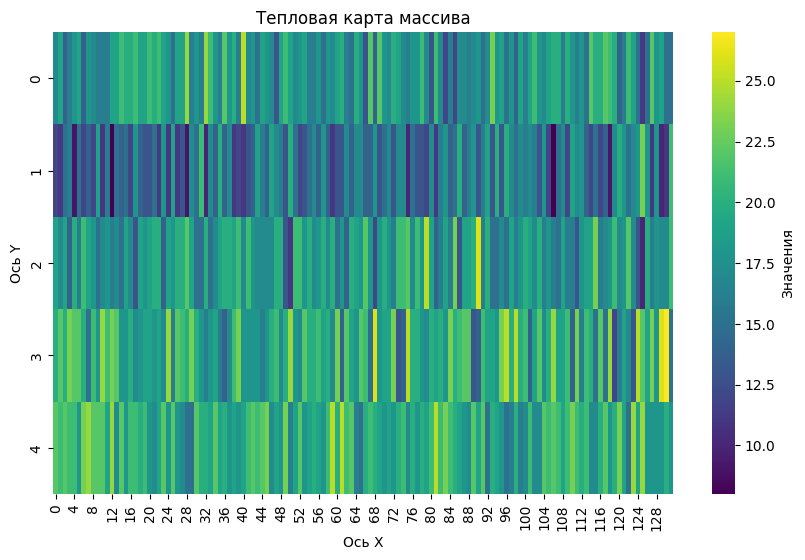

sub-10


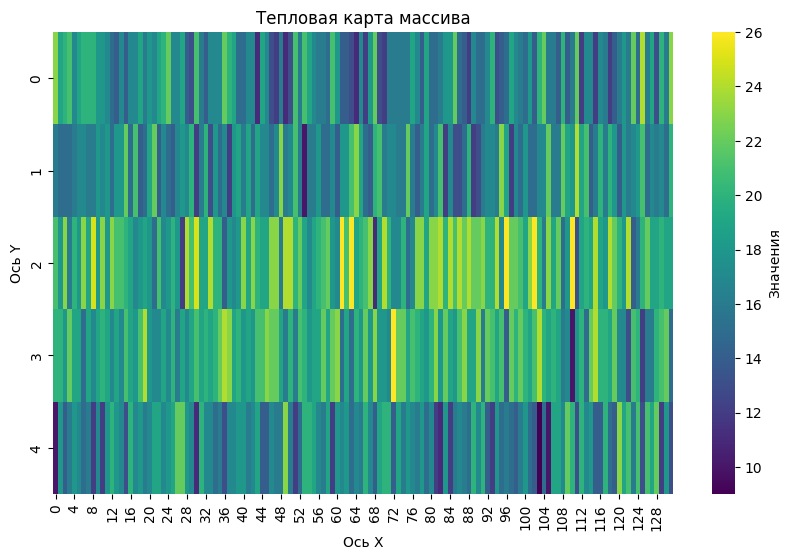

sub-11


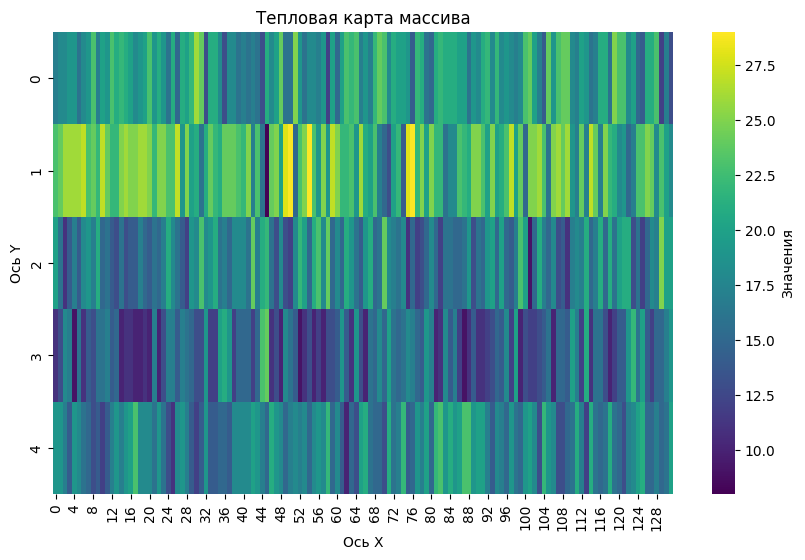

sub-12


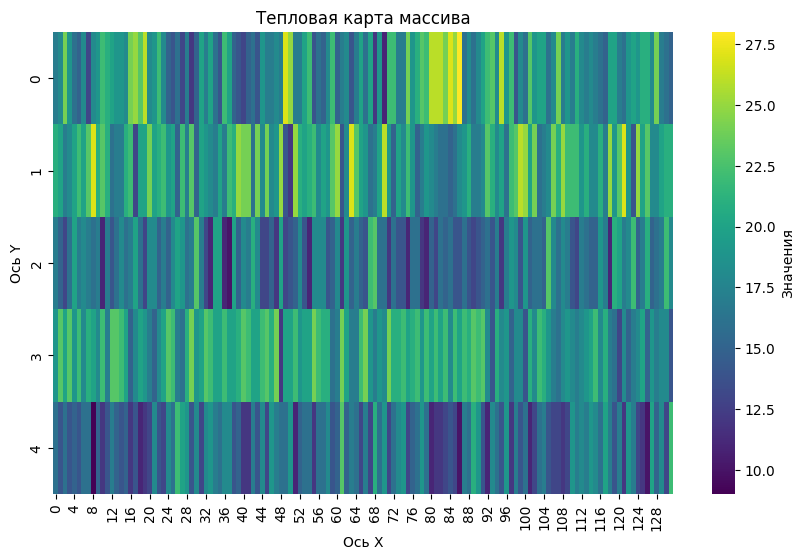

sub-13


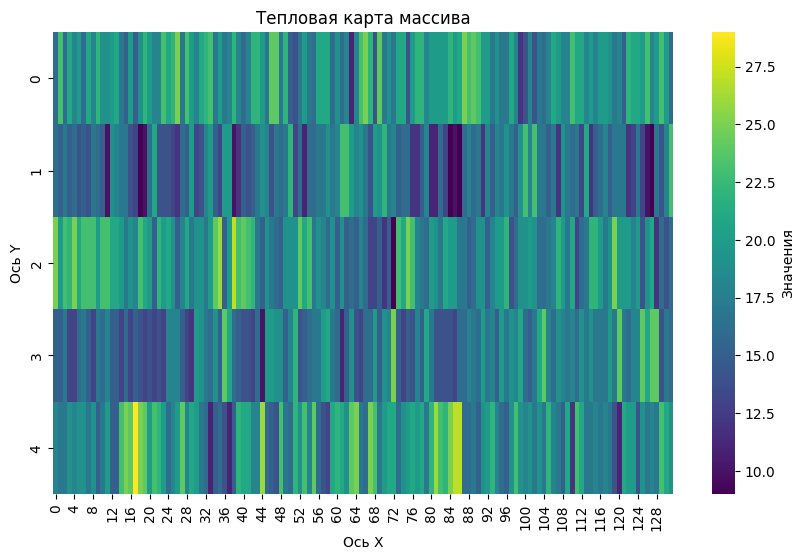

sub-14


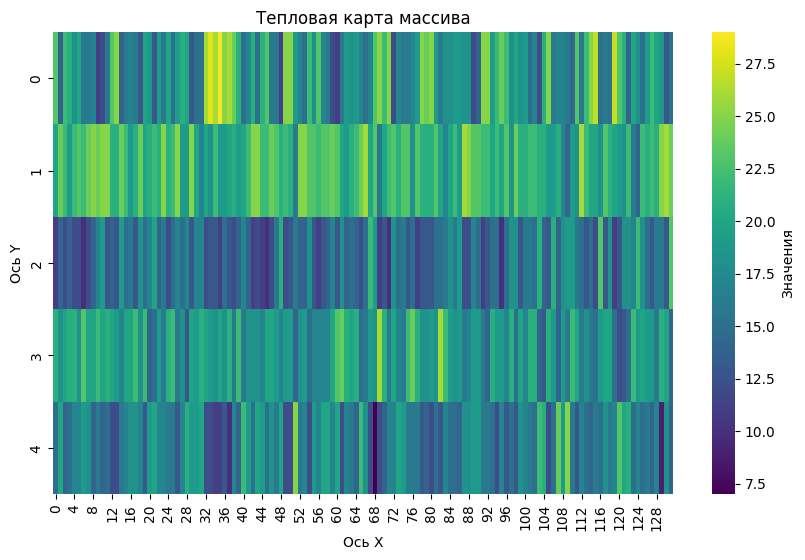

sub-15


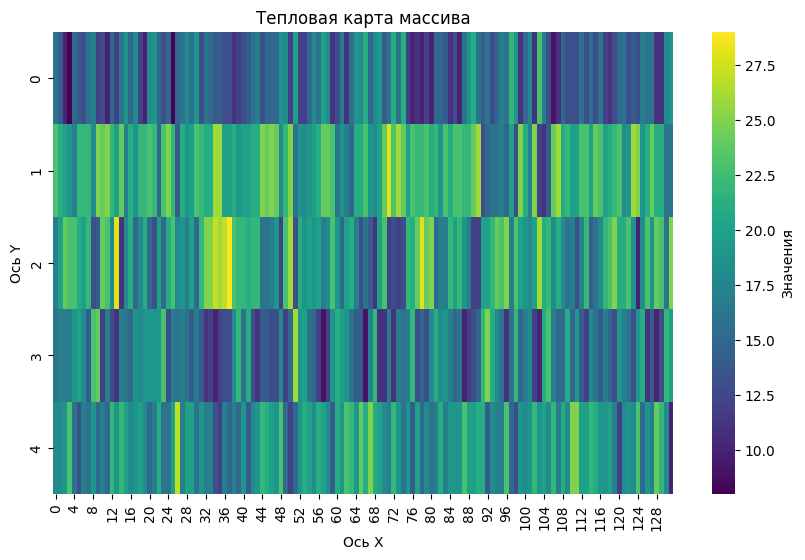

sub-16


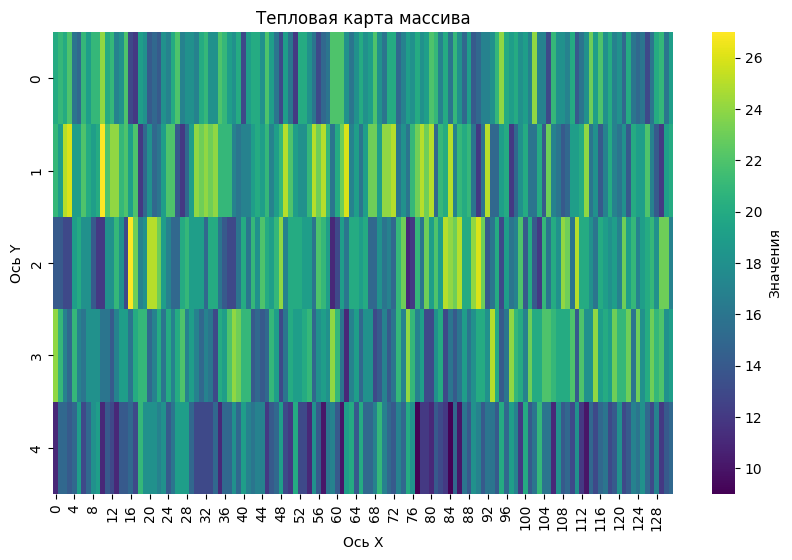

In [16]:
import os
draw_all_subjects(np.load(os.path.join(ranks_card_hc_matrix, 'max.npy')))